In [1]:
import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import time

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.13.0


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import os
import os.path
from pathlib import Path

import glob

from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf


from warnings import filterwarnings

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [4]:

train = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")
sub = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv")
train_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/")
test_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/")
print ('Train:', train.shape[0])
print ('Sub:', sub.shape[0])

Train: 4516842
Sub: 727392


In [5]:

train['type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]
train['filename'] = train['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
# Remove invalid PNGs
train=train.head(150000)

sub['type'] = sub['ID'].apply(lambda st: st.split('_')[2])
sub['PatientID'] = sub['ID'].str.split("_", n = 3, expand = True)[1]
sub['filename'] = sub['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub=sub.head(150000)
train.head()

,ID,Label,type,PatientID,filename
0,ID_12cadc6af_epidural,0,epidural,12cadc6af,ID_12cadc6af.png
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af,ID_12cadc6af.png
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af,ID_12cadc6af.png
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af,ID_12cadc6af.png
4,ID_12cadc6af_subdural,0,subdural,12cadc6af,ID_12cadc6af.png


In [6]:
sub.head()

,ID,Label,type,PatientID,filename
0,ID_0fbf6a978_epidural,0.5,epidural,0fbf6a978,ID_0fbf6a978.png
1,ID_0fbf6a978_intraparenchymal,0.5,intraparenchymal,0fbf6a978,ID_0fbf6a978.png
2,ID_0fbf6a978_intraventricular,0.5,intraventricular,0fbf6a978,ID_0fbf6a978.png
3,ID_0fbf6a978_subarachnoid,0.5,subarachnoid,0fbf6a978,ID_0fbf6a978.png
4,ID_0fbf6a978_subdural,0.5,subdural,0fbf6a978,ID_0fbf6a978.png


In [7]:
print ('Train type =', list(train.type.unique()))
print ('Train label =', list(train.Label.unique()))

Train type = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
Train label = [0, 1]


In [8]:
print ('Number of Patients: ', train.PatientID.nunique())

Number of Patients:  24999


In [9]:
print("Number of Patients in the sub: ", sub.PatientID.nunique())
sub.type.value_counts()

Number of Patients in the sub:  25000


type
epidural            25000
intraparenchymal    25000
intraventricular    25000
subarachnoid        25000
subdural            25000
any                 25000
Name: count, dtype: int64

In [10]:
train.type.value_counts()

type
epidural            25000
intraparenchymal    25000
intraventricular    25000
subarachnoid        25000
subdural            25000
any                 25000
Name: count, dtype: int64

Label
0    141404
1      8596
Name: count, dtype: int64


<Axes: xlabel='Label', ylabel='count'>

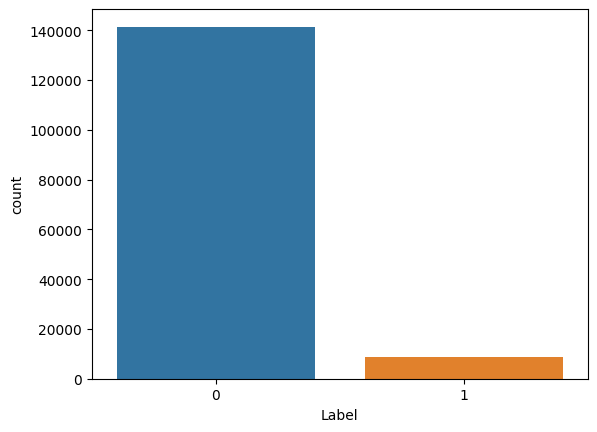

In [11]:

print(train.Label.value_counts())
sns.countplot(x='Label', data=train)

Label
0.5    150000
Name: count, dtype: int64


<Axes: xlabel='Label', ylabel='count'>

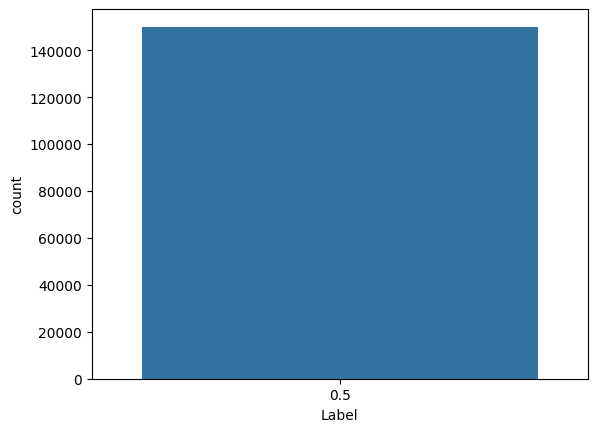

In [12]:
print(sub.Label.value_counts())
sns.countplot(x='Label', data=sub)

Label
0    10000
1     8596
Name: count, dtype: int64


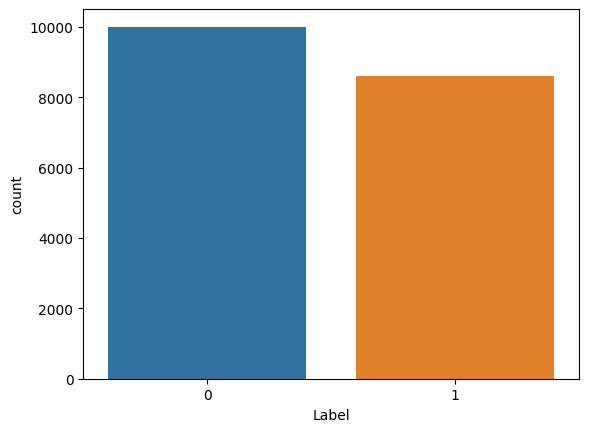

In [13]:

filtered_train = train[train['Label'].isin([0, 1])]

label_0_subset = filtered_train[filtered_train['Label'] == 0].sample(n=10000, random_state=1)
label_1_subset = filtered_train[filtered_train['Label'] == 1].sample(n=8596, random_state=1)

balanced_train = pd.concat([label_0_subset, label_1_subset])

print(balanced_train['Label'].value_counts())

sns.countplot(x='Label', data=balanced_train)

plt.show()


In [14]:
balanced_train.groupby('type').Label.value_counts()

type              Label
any               1        3618
                  0        1533
epidural          0        1769
                  1         116
intraparenchymal  0        1703
                  1        1236
intraventricular  0        1758
                  1         863
subarachnoid      0        1625
                  1        1182
subdural          0        1612
                  1        1581
Name: count, dtype: int64

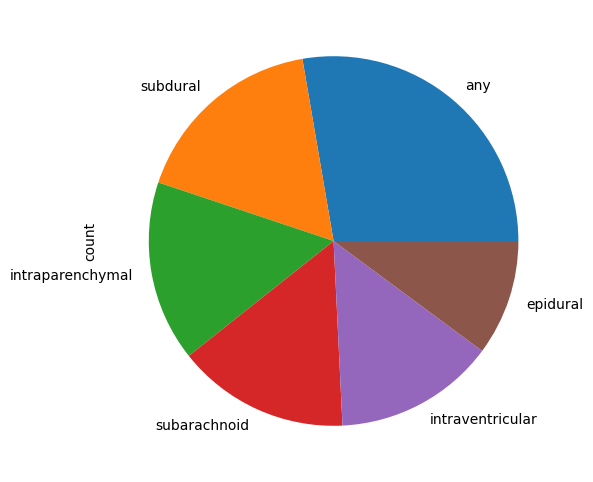

In [15]:
balanced_train.type.value_counts().plot.pie(figsize=(6,6))
plt.show()

In [16]:

TRAIN_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"
TEST_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/"
BASE_PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'

def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

    
    
def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        data = pydicom.read_file(os.path.join(TRAIN_IMG_PATH,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

data Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.125846227819956469853355733412611275406
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_4b08fe185
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_6338c4f1'
(0020, 000d) Study Instance UID                  UI: ID_a3b607ba3f
(0020, 000e) Series Instance UID                 UI: ID_468e9dedde
(0020, 0010) Study ID                            

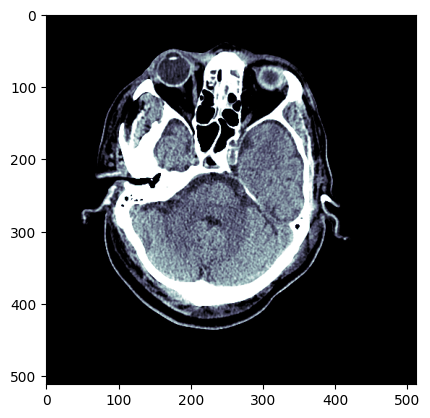

In [17]:
import pydicom
case = 8
data = pydicom.dcmread(TRAIN_IMG_PATH+train_images[case])

print("data",data)
window_center , window_width, intercept, slope = get_windowing(data)


#displaying the image
img = pydicom.read_file(TRAIN_IMG_PATH+train_images[case]).pixel_array

img = window_image(img, window_center, window_width, intercept, slope)
plt.imshow(img, cmap=plt.cm.bone)
plt.grid(False)

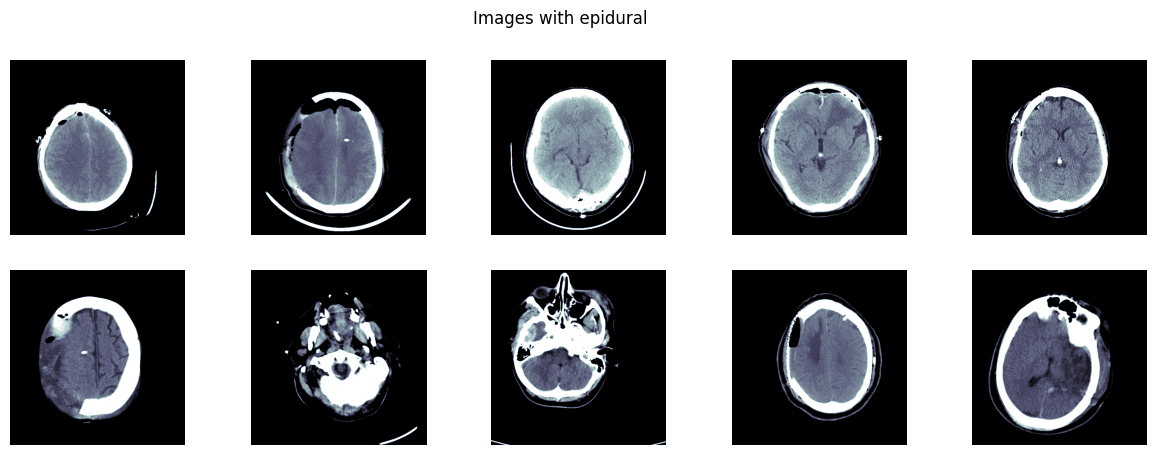

In [18]:
view_images(balanced_train[(train['type'] == 'epidural') & (balanced_train['Label'] == 1)][:10].PatientID.values, title = 'Images with epidural')

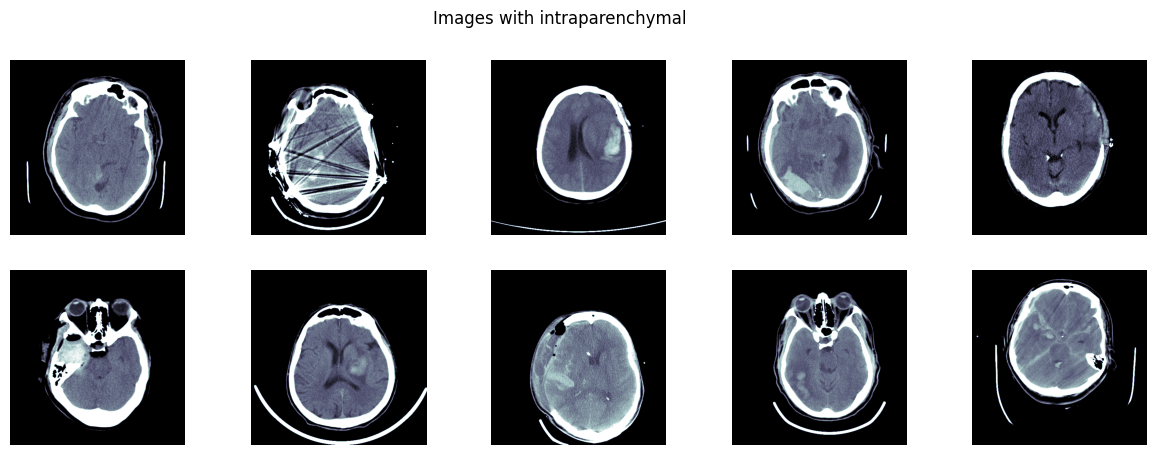

In [19]:
view_images(balanced_train[(balanced_train['type'] == 'intraparenchymal') & (balanced_train['Label'] == 1)][:10].PatientID.values, title = 'Images with intraparenchymal')

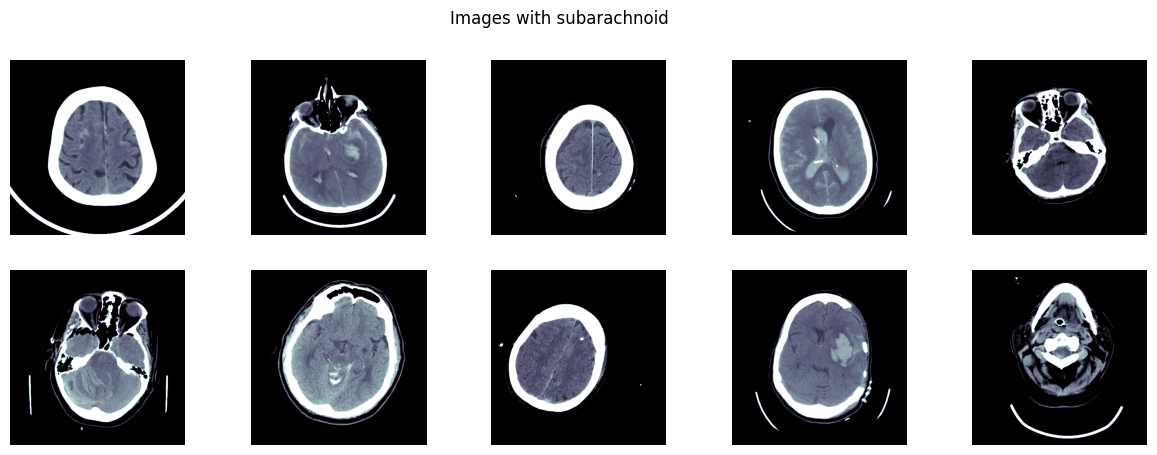

In [20]:
view_images(balanced_train[(train['type'] == 'subarachnoid') & (balanced_train['Label'] == 1)][:10].PatientID.values, title = 'Images with subarachnoid')

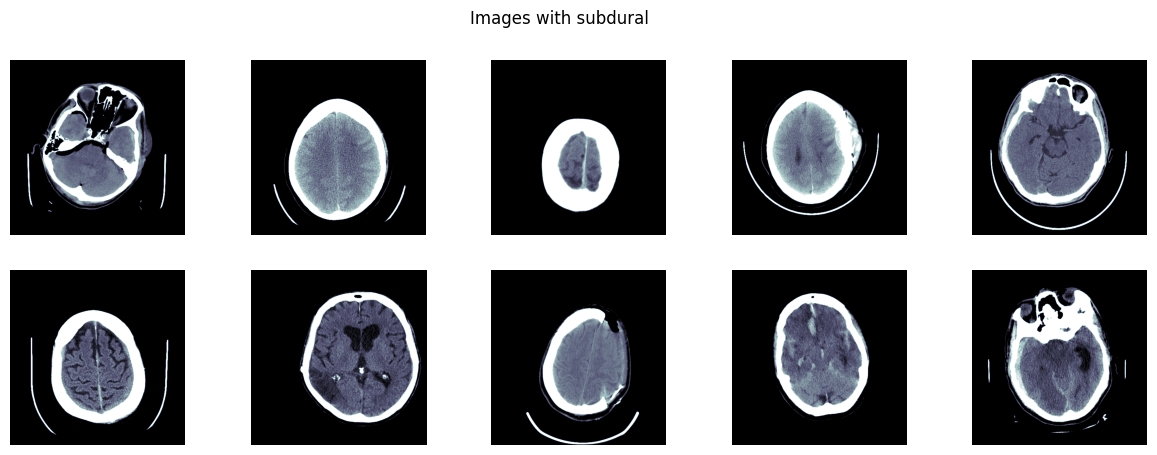

In [21]:
view_images(balanced_train[(balanced_train['type'] == 'subdural') & (balanced_train['Label'] == 1)][:10].PatientID.values, title = 'Images with subdural')

In [22]:
test = pd.DataFrame(sub.filename.unique(), columns=['filename'])
test = test.head(15000)
print ('Test:', test.shape[0])

Test: 15000


In [23]:
balanced_train.shape

(18596, 5)

In [24]:
np.random.seed(1234)
sample_files = np.random.choice(os.listdir(TRAIN_IMG_PATH), 1500000)

balanced_train_files = balanced_train['filename'].apply(lambda x: x.replace('.png', '.dcm')).tolist()

sample_files = np.random.choice(balanced_train_files, 18596, replace=False)

sample_df = balanced_train[balanced_train['filename'].apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]
print(sample_df.shape)

pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)

# Replace NaN values with 0
pivot_df = pivot_df.fillna(0)

# Display the first few rows of the pivot DataFrame
pivot_df.head()


(18596, 5)
(11243, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000680744.png,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_000920cd1.png,0.0,0.0,0.0,0.0,0.0,0.0
2,ID_0009c4591.png,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_0009e5f5e.png,1.0,0.0,1.0,0.0,0.0,0.0
4,ID_001097115.png,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
np.random.seed(1234)
sample_files_test = np.random.choice(os.listdir(TEST_IMG_PATH), 15000)
sample_files_test_df = sub[sub.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files_test)]
print(sample_files_test_df.shape)

pivot_test_df = sample_files_test_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_test_df.shape)
pivot_test_df.head()

(16956, 5)
(2826, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00235d45f.png,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_002c28d06.png,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_007940f41.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_00b2c9c46.png,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_00c89f0e9.png,0.5,0.5,0.5,0.5,0.5,0.5


In [26]:
def save_and_resize(filenames, load_dir):    
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        path = load_dir + filename
        new_path = save_dir + filename.replace('.dcm', '.png')
        
        dcm = pydicom.dcmread(path)
        window_center , window_width, intercept, slope = get_windowing(dcm)
        img = dcm.pixel_array
        img = window_image(img, window_center, window_width, intercept, slope)
        
        resized = cv2.resize(img, (224, 224))
        res = cv2.imwrite(new_path, resized)
        if not res:
            print('Failed')

In [27]:
from tqdm import tqdm
import json
import cv2

save_and_resize(filenames=sample_files, load_dir=BASE_PATH + TRAIN_DIR)
save_and_resize(filenames=sample_files_test, load_dir=BASE_PATH + TEST_DIR)
#save_and_resize(filenames=os.listdir(BASE_PATH + TEST_DIR), load_dir=BASE_PATH + TEST_DIR)

100%|██████████| 15000/15000 [04:37<00:00, 54.02it/s]


In [28]:
BATCH_SIZE = 16

def create_datagen():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        vertical_flip=True,  
        validation_split=0.25
    )

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test,
        directory='/kaggle/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        pivot_df, 
        directory='/kaggle/tmp/',
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='other',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_generator = create_test_gen()

Found 8433 validated image filenames.
Found 2810 validated image filenames.
Found 1718 validated image filenames.


In [29]:
# checking training set and its output
for data_batch,label_batch in train_gen:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 224, 224, 3)
LABEL SHAPE:  (16, 6)


In [30]:
# check validation set and its output
for data_batch,label_batch in val_gen:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 224, 224, 3)
LABEL SHAPE:  (16, 6)


In [31]:
import numpy as np
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
 data_batch, label_batch, test_size=0.33, random_state=42)

In [33]:
X_train.shape

(10, 224, 224, 3)

In [34]:
from tensorflow.keras.applications import xception
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model
branch1 = ResNet50(weights = 'imagenet')

branch1.layers.pop()

# Freeze the layers of the pre-trained model
for layer in branch1.layers:
    layer.trainable = False

# Get the output of the second to last layer
last = branch1.layers[-2].output

# Add a custom classification head
x = Dense(6, activation="sigmoid")(last)

# Create the final model
finetuned_model_1 = Model(branch1.input, x, name="Branch_1")
finetuned_model_1.summary()
finetuned_model_1.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy', 'mse', 'mae', 'mape', 'cosine'])

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

102967424/102967424 [==============================] - 1s 0us/step
Model: "Branch_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model
branch2 = MobileNetV2(weights='imagenet')
branch2.layers.pop()

# Freeze the layers of the pre-trained model
for layer in branch2.layers:
    layer.trainable = False

# Get the output of the second to last layer
last = branch2.layers[-2].output

# Add a custom classification head
x = Dense(6, activation="sigmoid")(last)

# Create the final model
finetuned_model_2 = Model(branch2.input, x, name="Branch_2")
finetuned_model_2.summary()
finetuned_model_2.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy', 'mse', 'mae', 'mape', 'cosine'])

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

14536120/14536120 [==============================] - 0s 0us/step
Model: "Branch_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)        

In [37]:
len(train_gen)
len(val_gen)

176

In [38]:
len(test_generator)

108

In [41]:
from tensorflow.keras.layers import concatenate


print('Getting training features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_features=model1.predict(train_gen)
model1_features=pd.DataFrame(model1_features)
print("Branch1_features", model1_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_features=model2.predict(train_gen)
model2_features=pd.DataFrame(model2_features)
print("Branch2_features", model2_features.shape)

concatenated_features=pd.concat([model1_features,model2_features], axis=1)
print("Combined_features", concatenated_features.shape)

print('Getting validation features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_val_features=model1.predict(val_gen)
model1_val_features=pd.DataFrame(model1_val_features)
print("Branch1_val_features", model1_val_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_val_features=model2.predict(val_gen)
model2_val_features=pd.DataFrame(model2_val_features)
print("Branch2_val_features", model2_val_features.shape)

concatenated_val_features=pd.concat([model1_val_features,model2_val_features], axis=1)
print("Combined_val_features", concatenated_val_features.shape)

Getting training features and concatenation---------------start
528/528 [==============================] - 855s 2s/step
Branch1_features (8433, 2048)
528/528 [==============================] - 214s 403ms/step
Branch2_features (8433, 1280)
Combined_features (8433, 3328)
Getting validation features and concatenation---------------start
176/176 [==============================] - 289s 2s/step
Branch1_val_features (2810, 2048)
176/176 [==============================] - 73s 406ms/step
Branch2_val_features (2810, 1280)
Combined_val_features (2810, 3328)


In [42]:

feature_train_labels=pd.DataFrame(train_gen.labels)
print(feature_train_labels)


feature_test_labels=pd.DataFrame(val_gen.labels)
len(feature_test_labels.shape)



        0    1    2    3    4    5
0     1.0  0.0  1.0  1.0  1.0  0.0
1     0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0
4     1.0  0.0  0.0  0.0  1.0  0.0
...   ...  ...  ...  ...  ...  ...
8428  1.0  1.0  0.0  0.0  1.0  0.0
8429  0.0  0.0  0.0  0.0  0.0  0.0
8430  0.0  0.0  0.0  0.0  0.0  0.0
8431  1.0  0.0  1.0  1.0  0.0  0.0
8432  1.0  0.0  0.0  0.0  0.0  1.0

[8433 rows x 6 columns]


2

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(concatenated_features,feature_train_labels)
knn.fit(concatenated_val_features,feature_test_labels)
print("done training")

pred_knn= knn.predict(concatenated_val_features)
print("pred_KNN",pred_knn.shape)


accuracy=accuracy_score(feature_test_labels,pred_knn.round())
print("Accuracy of combined model with KNN: {0:0.4f}".format(accuracy*100))

f1score=f1_score(pred_knn,feature_test_labels, average='weighted')
print("F1score of combined model with KNN: {0:0.4f}".format( f1score))

recall = recall_score(feature_test_labels,pred_knn, average='weighted')
print('Recall score of combined model with KNN: {0:0.4f}'.format(recall))

precision = precision_score(pred_knn.round(),feature_test_labels,average='weighted')
print('Precision of combined model with KNN: {0:0.4f}'.format(precision))


done training
pred_KNN (2810, 6)
Accuracy of combined model with KNN: 64.0925
F1score of combined model with KNN: 0.3482
Recall score of combined model with KNN: 0.1247
Precision of combined model with KNN: 0.2476


In [45]:
concatenated_features_1=pd.concat([model1_features,model1_features], axis=1)
print("Combined_features", concatenated_features_1.shape)

concatenated_val_features_1=pd.concat([model1_val_features,model1_val_features], axis=1)
print("Combined_val_features", concatenated_val_features_1.shape)



Combined_features (8433, 4096)
Combined_val_features (2810, 4096)


In [46]:
concatenated_features_2=pd.concat([model2_features,model2_features], axis=1)
print("Combined_features", concatenated_features_2.shape)

concatenated_val_features_2=pd.concat([model2_val_features,model2_val_features], axis=1)
print("Combined_val_features", concatenated_val_features_2.shape)

Combined_features (8433, 2560)
Combined_val_features (2810, 2560)


In [48]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

knn1 = KNeighborsClassifier(n_neighbors=7)

knn1.fit(concatenated_features_1,feature_train_labels)
knn1.fit(concatenated_val_features_1,feature_test_labels)
print("done training")

pred_knn1= knn1.predict(concatenated_val_features_1)
print("pred_KNN",pred_knn.shape)


accuracy=accuracy_score(feature_test_labels,pred_knn1.round())
print("Accuracy of combined model with KNN: {0:0.4f}".format(accuracy*100))

f1score=f1_score(pred_knn1,feature_test_labels, average='weighted')
print("F1score of combined model with KNN: {0:0.4f}".format( f1score))


recall = recall_score(feature_test_labels,pred_knn1, average='weighted')
print('Recall score of combined model with KNN: {0:0.4f}'.format(recall))


precision = precision_score(pred_knn1.round(),feature_test_labels,average='weighted')
print('Precision of combined model with KNN: {0:0.4f}'.format(precision))
 

done training
pred_KNN (2810, 6)
Accuracy of combined model with KNN: 64.0569
F1score of combined model with KNN: 0.3475
Recall score of combined model with KNN: 0.1356
Precision of combined model with KNN: 0.2488


In [49]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

knn2 = KNeighborsClassifier(n_neighbors=7)

knn2.fit(concatenated_features_2,feature_train_labels)
knn1.fit(concatenated_val_features_2,feature_test_labels)
print("done training")

pred_knn2= knn2.predict(concatenated_val_features_2)
print("pred_KNN",pred_knn.shape)


accuracy=accuracy_score(feature_test_labels,pred_knn2.round())
print("Accuracy of combined model with KNN: {0:0.4f}".format(accuracy*100))

f1score=f1_score(pred_knn2,feature_test_labels, average='weighted')
print("F1score of combined model with KNN: {0:0.4f}".format( f1score))


recall = recall_score(feature_test_labels,pred_knn2, average='weighted')
print('Recall score of combined model with KNN: {0:0.4f}'.format(recall))


precision = precision_score(pred_knn2.round(),feature_test_labels,average='weighted')
print('Precision of combined model with KNN: {0:0.4f}'.format(precision))
 

done training
pred_KNN (2810, 6)
Accuracy of combined model with KNN: 58.0427
F1score of combined model with KNN: 0.1954
Recall score of combined model with KNN: 0.0740
Precision of combined model with KNN: 0.1459


In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score


dt_classifier = DecisionTreeClassifier(random_state=42)


dt_classifier.fit(concatenated_features, feature_train_labels)
dt_classifier.fit(concatenated_val_features, feature_test_labels)
print("done training")


pred_dt = dt_classifier.predict(concatenated_val_features)
print("pred_DT", pred_dt.shape)


accuracy = accuracy_score(feature_test_labels, pred_dt)
print("Accuracy of combined model with Decision Tree: {0:0.4f}".format(accuracy * 100))


f1score = f1_score(feature_test_labels, pred_dt, average='weighted')
print("F1score of combined model with Decision Tree: {0:0.4f}".format(f1score ))


recall = recall_score(feature_test_labels, pred_dt, average='weighted')
print('Recall score of combined model with Decision Tree: {0:0.4f}'.format(recall ))

precision = precision_score(feature_test_labels, pred_dt, average='weighted')
print('Precision of combined model with Decision Tree: {0:0.4f}'.format(precision ))


done training
pred_DT (2810, 6)
Accuracy of combined model with Decision Tree: 100.0000
F1score of combined model with Decision Tree: 1.0000
Recall score of combined model with Decision Tree: 1.0000
Precision of combined model with Decision Tree: 1.0000


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
 data_batch, label_batch, test_size=0.40, random_state=42)

In [53]:
from tensorflow.keras.layers import concatenate


print('Getting training features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_features=model1.predict(train_gen)
model1_features=pd.DataFrame(model1_features)
print("Branch1_features", model1_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_features=model2.predict(train_gen)
model2_features=pd.DataFrame(model2_features)
print("Branch2_features", model2_features.shape)

concatenated_features=pd.concat([model1_features,model2_features], axis=1)
print("Combined_features", concatenated_features.shape)

print('Getting validation features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_val_features=model1.predict(val_gen)
model1_val_features=pd.DataFrame(model1_val_features)
print("Branch1_val_features", model1_val_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_val_features=model2.predict(val_gen)
model2_val_features=pd.DataFrame(model2_val_features)
print("Branch2_val_features", model2_val_features.shape)

concatenated_val_features=pd.concat([model1_val_features,model2_val_features], axis=1)
print("Combined_val_features", concatenated_val_features.shape)

Getting training features and concatenation---------------start
528/528 [==============================] - 825s 2s/step
Branch1_features (8433, 2048)
528/528 [==============================] - 217s 409ms/step
Branch2_features (8433, 1280)
Combined_features (8433, 3328)
Getting validation features and concatenation---------------start
176/176 [==============================] - 274s 2s/step
Branch1_val_features (2810, 2048)
176/176 [==============================] - 72s 401ms/step
Branch2_val_features (2810, 1280)
Combined_val_features (2810, 3328)


In [54]:
feature_train_labels=pd.DataFrame(train_gen.labels)
print(feature_train_labels)


feature_test_labels=pd.DataFrame(val_gen.labels)
len(feature_test_labels.shape)


        0    1    2    3    4    5
0     1.0  0.0  1.0  1.0  1.0  0.0
1     0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0
4     1.0  0.0  0.0  0.0  1.0  0.0
...   ...  ...  ...  ...  ...  ...
8428  1.0  1.0  0.0  0.0  1.0  0.0
8429  0.0  0.0  0.0  0.0  0.0  0.0
8430  0.0  0.0  0.0  0.0  0.0  0.0
8431  1.0  0.0  1.0  1.0  0.0  0.0
8432  1.0  0.0  0.0  0.0  0.0  1.0

[8433 rows x 6 columns]


2

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(concatenated_features,feature_train_labels)
print("done training")

pred_knn= knn.predict(concatenated_val_features)
print("pred_KNN",pred_knn.shape)


accuracy=accuracy_score(feature_test_labels,pred_knn.round())
print("Accuracy of combined model with KNN: {0:0.4f}".format(accuracy*100))

f1score=f1_score(pred_knn,feature_test_labels, average='weighted')
print("F1score of combined model with KNN: {0:0.4f}".format( f1score))

recall = recall_score(feature_test_labels,pred_knn, average='weighted')
print('Recall score of combined model with KNN: {0:0.4f}'.format(recall))

precision = precision_score(pred_knn.round(),feature_test_labels,average='weighted')
print('Precision of combined model with KNN: {0:0.4f}'.format(precision))

done training
pred_KNN (2810, 6)
Accuracy of combined model with KNN: 56.9039
F1score of combined model with KNN: 0.2021
Recall score of combined model with KNN: 0.0754
Precision of combined model with KNN: 0.1554


In [56]:
concatenated_features_1=pd.concat([model1_features,model1_features], axis=1)
print("Combined_features", concatenated_features_1.shape)

concatenated_val_features_1=pd.concat([model1_val_features,model1_val_features], axis=1)
print("Combined_val_features", concatenated_val_features_1.shape)


Combined_features (8433, 4096)
Combined_val_features (2810, 4096)


In [57]:
from sklearn.metrics import precision_score, f1_score, recall_score

knn1 = KNeighborsClassifier(n_neighbors=7)

knn1.fit(concatenated_features_1,feature_train_labels)
print("done training")

pred_knn1= knn1.predict(concatenated_val_features_1)
print("pred_KNN",pred_knn.shape)


accuracy=accuracy_score(feature_test_labels,pred_knn1.round())
print("Accuracy of model 1 with KNN: {0:0.4f}".format(accuracy*100))

f1score=f1_score(pred_knn1,feature_test_labels, average='weighted')
print("F1score of model 1 with KNN: {0:0.4f}".format( f1score))


recall = recall_score(feature_test_labels,pred_knn1, average='weighted')
print('Recall score of model 1 with KNN: {0:0.4f}'.format(recall))


precision = precision_score(pred_knn1.round(),feature_test_labels,average='weighted')
print('Precision of model 1 with KNN: {0:0.4f}'.format(precision))

done training
pred_KNN (2810, 6)
Accuracy of model 1 with KNN: 58.0427
F1score of model 1 with KNN: 0.1748
Recall score of model 1 with KNN: 0.0626
Precision of model 1 with KNN: 0.1286


In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score


dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(concatenated_features, feature_train_labels)
print("done training")

pred_dt = dt_classifier.predict(concatenated_val_features)
print("pred_DT", pred_dt.shape)

accuracy = accuracy_score(feature_test_labels, pred_dt)
print("Accuracy of combined model with Decision Tree: {0:0.4f}".format(accuracy * 100))

f1score = f1_score(feature_test_labels, pred_dt, average='weighted')
print("F1score of combined model with Decision Tree: {0:0.4f}".format(f1score ))

recall = recall_score(feature_test_labels, pred_dt, average='weighted')
print('Recall score of combined model with Decision Tree: {0:0.4f}'.format(recall ))

precision = precision_score(feature_test_labels, pred_dt, average='weighted')
print('Precision of combined model with Decision Tree: {0:0.4f}'.format(precision ))


done training
pred_DT (2810, 6)
Accuracy of combined model with Decision Tree: 45.7295
F1score of combined model with Decision Tree: 0.1879
Recall score of combined model with Decision Tree: 0.1963
Precision of combined model with Decision Tree: 0.1803


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

rf_classifier = RandomForestClassifier(n_estimators=95)

multi_rf_classifier = OneVsRestClassifier(rf_classifier)

multi_rf_classifier.fit(concatenated_features, feature_train_labels)
print("done training")

pred_rf = multi_rf_classifier.predict(concatenated_val_features)
print("pred_RF", pred_rf.shape)

accuracy = accuracy_score(feature_test_labels, pred_rf)
print("Accuracy of combined model with Random Forest: {0:0.4f}".format(accuracy * 100))

f1score = f1_score(feature_test_labels, pred_rf, average='weighted')
print("F1score of combined model with Random Forest: {0:0.4f}".format(f1score))

recall = recall_score(feature_test_labels, pred_rf, average='weighted')
print('Recall score of combined model with Random Forest: {0:0.4f}'.format(recall))

precision = precision_score(feature_test_labels, pred_rf, average='weighted')
print('Precision of combined model with Random Forest: {0:0.4f}'.format(precision))


done training
pred_RF (2810, 6)
Accuracy of combined model with Random Forest: 67.7580
F1score of combined model with Random Forest: 0.0074
Recall score of combined model with Random Forest: 0.0038
Precision of combined model with Random Forest: 0.1246


In [60]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

ada_classifier = AdaBoostClassifier(n_estimators=100)

multi_ada_classifier = OneVsRestClassifier(ada_classifier)

multi_ada_classifier.fit(concatenated_features, feature_train_labels)

print("done training")

pred_ada = multi_ada_classifier.predict(concatenated_val_features)
print("pred_AdaBoost", pred_ada.shape)

accuracy = accuracy_score(feature_test_labels, pred_ada)
print("Accuracy of combined model with AdaBoost: {0:0.4f}".format(accuracy * 100))

f1score = f1_score(feature_test_labels, pred_ada, average='weighted')
print("F1score of combined model with AdaBoost: {0:0.4f}".format(f1score))

recall = recall_score(feature_test_labels, pred_ada, average='weighted')
print('Recall score of combined model with AdaBoost: {0:0.4f}'.format(recall))

precision = precision_score(feature_test_labels, pred_ada, average='weighted')
print('Precision of combined model with AdaBoost: {0:0.4f}'.format(precision))


done training
pred_AdaBoost (2810, 6)
Accuracy of combined model with AdaBoost: 56.6548
F1score of combined model with AdaBoost: 0.0831
Recall score of combined model with AdaBoost: 0.0564
Precision of combined model with AdaBoost: 0.1757


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

logreg_classifier = LogisticRegression()

multi_logreg_classifier = OneVsRestClassifier(logreg_classifier)

multi_logreg_classifier.fit(concatenated_features, feature_train_labels)
print("done training")

pred_logreg = multi_logreg_classifier.predict(concatenated_val_features)
print("pred_LogReg", pred_logreg.shape)

accuracy = accuracy_score(feature_test_labels, pred_logreg)
print("Accuracy of combined model with Logistic Regression: {0:0.4f}".format(accuracy * 100))

f1score = f1_score(feature_test_labels, pred_logreg, average='weighted')
print("F1score of combined model with Logistic Regression: {0:0.4f}".format(f1score))

recall = recall_score(feature_test_labels, pred_logreg, average='weighted')
print('Recall score of combined model with Logistic Regression: {0:0.4f}'.format(recall))

precision = precision_score(feature_test_labels, pred_logreg, average='weighted')
print('Precision of combined model with Logistic Regression: {0:0.4f}'.format(precision))


done training
pred_LogReg (2810, 6)
Accuracy of combined model with Logistic Regression: 54.1637
F1score of combined model with Logistic Regression: 0.1159
Recall score of combined model with Logistic Regression: 0.0868
Precision of combined model with Logistic Regression: 0.1942


In [62]:
from sklearn.metrics import multilabel_confusion_matrix
cm1 = multilabel_confusion_matrix(feature_test_labels,pred_knn)
print(cm1)

[[[1595  328]
  [ 735  152]]

 [[2775    0]
  [  35    0]]

 [[2485   12]
  [ 311    2]]

 [[2596    1]
  [ 213    0]]

 [[2528   10]
  [ 271    1]]

 [[2399   22]
  [ 385    4]]]


In [63]:
first_cat=cm1[0]
tn, fp, fn, tp = first_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_1=(tp+tn)/(tp+tn+fp+fn)
print("fpr for any is :",fpr*100)
print("fnr for any is :  ",fnr*100)
print("TPR for any is : ",TPR*100)
print("TNR for any is : ",TNR*100)
print("Accuracy for any is ",acc_1*100)

second_cat=cm1[1]
tn, fp, fn, tp = second_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_2=(tp+tn)/(tp+tn+fp+fn)
print("fpr for epidural is :  ",fpr*100)
print("fnr for epidural is : ",fnr*100)
print("TPR for epidural is : ",TPR*100)
print("TNR for epidural is : ",TNR*100)
print("Accuracy for epidural is : ",acc_2*100)

third_cat=cm1[2]
tn, fp, fn, tp = third_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_3=(tp+tn)/(tp+tn+fp+fn)
print("fpr for intraparenchymal is : ",fpr*100)
print("fnr for intraparenchymal is : ",fnr*100)
print("TPR for intraparenchymal is : ",TPR*100)
print("TNR for intraparenchymal is : ",TNR*100)
print("Accuracy for intraparenchymal is ",acc_3*100)

fourth_cat=cm1[3]
tn, fp, fn, tp = fourth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_4=(tp+tn)/(tp+tn+fp+fn)
print("fpr for intraventricular is : ",fpr*100)
print("fnr for intraventricular is :  ",fnr*100)
print("TPR for intraventricular is : ",TPR*100)
print("TNR for intraventricular is : ",TNR*100)
print("Accuracy for intraventricular : is ",acc_4*100)

fifth_cat=cm1[4]
tn, fp, fn, tp = fourth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_5=(tp+tn)/(tp+tn+fp+fn)
print("fpr for subarachnoid is  : ",fpr*100)
print("fnr for subarachnoid is :  ",fnr*100)
print("TPR for subarachnoid is : ",TPR*100)
print("TNR for subarachnoid is : ",TNR*100)
print("Accuracy for subarachnoid is :  ",acc_5*100)

sixth_cat=cm1[5]
tn, fp, fn, tp = sixth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_6=(tp+tn)/(tp+tn+fp+fn)
print("fpr for subdural is : ",fpr*100)
print("fnr for subdural is : ",fnr*100)
print("TPR for subdural is : ",TPR*100)
print("TNR for subdural is :",TNR*100)
print("Accuracy for Subdural is ",acc_6*100)

fpr for any is : 17.05668226729069
fnr for any is :   82.86358511837655
TPR for any is :  17.13641488162345
TNR for any is :  82.9433177327093
Accuracy for any is  62.170818505338076
fpr for epidural is :   0.0
fnr for epidural is :  100.0
TPR for epidural is :  0.0
TNR for epidural is :  100.0
Accuracy for epidural is :  98.75444839857651
fpr for intraparenchymal is :  0.4805766920304365
fnr for intraparenchymal is :  99.36102236421725
TPR for intraparenchymal is :  0.6389776357827476
TNR for intraparenchymal is :  99.51942330796956
Accuracy for intraparenchymal is  88.50533807829181
fpr for intraventricular is :  0.03850596842510589
fnr for intraventricular is :   100.0
TPR for intraventricular is :  0.0
TNR for intraventricular is :  99.96149403157489
Accuracy for intraventricular : is  92.38434163701068
fpr for subarachnoid is  :  0.03850596842510589
fnr for subarachnoid is :   100.0
TPR for subarachnoid is :  0.0
TNR for subarachnoid is :  99.96149403157489
Accuracy for subarachno

In [64]:
cm2 = multilabel_confusion_matrix(feature_test_labels,pred_dt)
print(cm2)

[[[1254  669]
  [ 599  288]]

 [[2752   23]
  [  35    0]]

 [[2195  302]
  [ 281   32]]

 [[2374  223]
  [ 197   16]]

 [[2238  300]
  [ 239   33]]

 [[2051  370]
  [ 344   45]]]


In [65]:
cm3 = multilabel_confusion_matrix(feature_test_labels,pred_rf)
print(cm3)

[[[1904   19]
  [ 879    8]]

 [[2775    0]
  [  35    0]]

 [[2497    0]
  [ 313    0]]

 [[2597    0]
  [ 213    0]]

 [[2538    0]
  [ 272    0]]

 [[2421    0]
  [ 389    0]]]


In [66]:
cm4 = multilabel_confusion_matrix(feature_test_labels,pred_ada)
print(cm4)

[[[1679  244]
  [ 782  105]]

 [[2771    4]
  [  35    0]]

 [[2465   32]
  [ 308    5]]

 [[2576   21]
  [ 213    0]]

 [[2504   34]
  [ 271    1]]

 [[2371   50]
  [ 381    8]]]


In [67]:
cm5 = multilabel_confusion_matrix(feature_test_labels,pred_logreg)
print(cm5)

[[[1582  341]
  [ 730  157]]

 [[2769    6]
  [  35    0]]

 [[2450   47]
  [ 305    8]]

 [[2537   60]
  [ 212    1]]

 [[2485   53]
  [ 265    7]]

 [[2352   69]
  [ 379   10]]]


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

def plot_and_save_heatmap(cm, labels, title, filename):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close() 

category_names = ['Any', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural']



In [69]:
for i in range(len(cm1)):
    cm = cm1[i]
    filename = f'confusion_matrix_pred_knn_{category_names[i].lower()}.png'
    plot_and_save_heatmap(cm, ['Negative', 'Positive'], f'Confusion Matrix for {category_names[i]}', filename)

In [70]:
for i in range(len(cm2)):
    cm = cm2[i]
    filename = f'confusion_matrix_pred_dt_{category_names[i].lower()}.png'
    plot_and_save_heatmap(cm, ['Negative', 'Positive'], f'Confusion Matrix for {category_names[i]}', filename)

In [71]:
for i in range(len(cm3)):
    cm = cm3[i]
    filename = f'confusion_matrix_pred_rf_{category_names[i].lower()}.png'
    plot_and_save_heatmap(cm, ['Negative', 'Positive'], f'Confusion Matrix for {category_names[i]}', filename)

In [72]:
for i in range(len(cm4)):
    cm = cm4[i]
    filename = f'confusion_matrix_pred_ada_{category_names[i].lower()}.png'
    plot_and_save_heatmap(cm, ['Negative', 'Positive'], f'Confusion Matrix for {category_names[i]}', filename)

In [73]:
for i in range(len(cm5)):
    cm = cm5[i]
    filename = f'confusion_matrix_pred_logreg_{category_names[i].lower()}.png'
    plot_and_save_heatmap(cm, ['Negative', 'Positive'], f'Confusion Matrix for {category_names[i]}', filename)